## Import necessary packages

In [1]:
%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import figure_factory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

## Load chest/lung images 
Image files are from The Cancer Imaging Archive (TCIA) from the NIH National Cancer Institute

In [2]:
data_path = "/Users/jihye/Projects/research/01_practice_images/NLST/100002/01-02-1999-NA-NLST-LSS-55322/1.000000-0OPAGELSPLUSD3602.512080.00.11.5-35858/"
output_path = working_path = "/Users/jihye/Projects/research/01_practice_images"
g = glob(data_path + '/*.dcm')

## Functions for loading files and converting to Hounsfield Units

In [10]:
# loop over image files and store everything into a list
def load_scan(path):    
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)] # os.listdir() gets list of all files and directories
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        # ImagePositionPatient returns x,y,z coor of upper left hand corner
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        # SliceLocation returns relative position of image plance in mm
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        # unit of distance in z-dir per slice (image)
        # less than 2mm; in order to optimize as much info
        s.SliceThickness = slice_thickness
        
    return slices

# convert pixels to Hounsfield Units (scale for describing radiodensity for medical images)
def get_pixels_hu(scans): # input is output from load_scans
    
    # pixel_array 
    # stack: join sequence of arrays along a new axis
    image = np.stack([s.pixel_array for s in scans])
    
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    # b in relationship between stored values SV and output units (m*SV + b)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

np.save(output_path + "/" + "fullimages_%d.npy" % (id), imgs)

## Histogram based on HU from the medical images

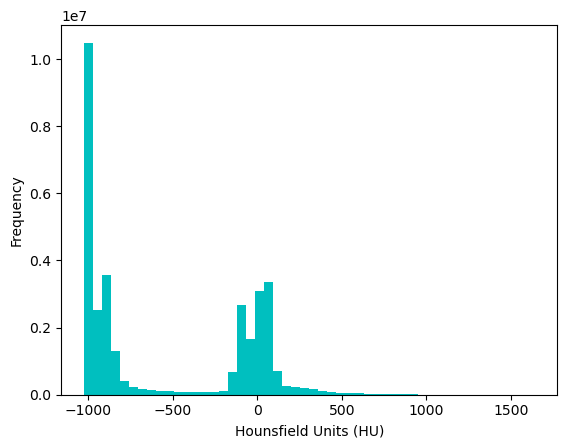

In [11]:
# displaying histogram based on HU
# histagram shows lots of air, some lung, lots of soft tissue (mostly muscle and liver, some fat), some bone
file_used=output_path+"/"+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

# flatten flattens the array: [[1,2], [3,4]] -> [1,2,3,4]
plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

## Selection of 2D images displayed in a stack

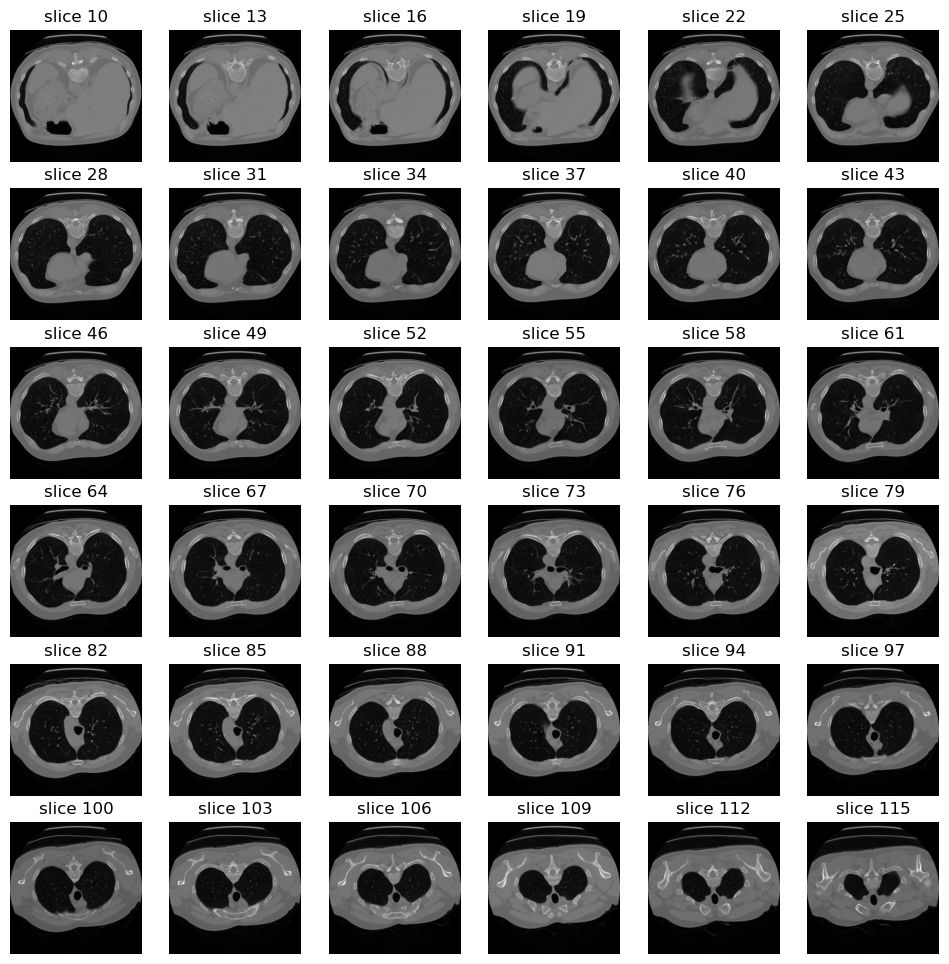

In [12]:
# displaying image stack
id = 0
imgs_to_process = np.flip(np.load(output_path + '/' + 'fullimages_{}.npy'.format(id)))

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        # imshow: display data as image
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

## Resample the image data to be isovoxel

In [6]:
# resampling
print("Slice Thickness: %f" % patient[0].SliceThickness)
# PixelSpacing returns the physical distance in mm between center of each pixel
# first value is space between rows (vertical distance); second value is space between col (horizontal distance)
print("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

id = 0
imgs_to_process = np.flip(np.load(output_path+'/' + 'fullimages_{}.npy'.format(id)))

# diff voxel resolution between patients; resample it to make it isovoxel
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    # change each item in list to float; create numpy array from list
    # spacing = list of distance between pixels in z, x, y directions
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing # array 
    new_real_shape = image.shape * resize_factor #shape: returns dimensions of image
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.zoom(image, real_resize_factor)
    
    return image, new_spacing

print("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)

# we have 2.5mm thick slices and each voxel represents 0.7mm. 
# CT is reconstructed at 512x512 voxels, each slce represents approx 370mm of data in len and width

Slice Thickness: 2.500000
Pixel Spacing (row, col): (0.703125, 0.703125) 
Shape before resampling	 (126, 512, 512)
Shape after resampling	 (315, 360, 360)


## Make a mesh and create a 3D visualization of the images

In [16]:
# 3D plotting
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface") 
    # original axes is 0,1,2; tranposed so axis 0 takes place of axis 2 and vice versa
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    # marching cubtes algorithm is used to generate 3D mesh from dataset
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor((0.7, 0.7, 0.7))
    
    ax.invert_yaxis()
    
    plt.show()


Transposing surface
Calculating surface
Drawing


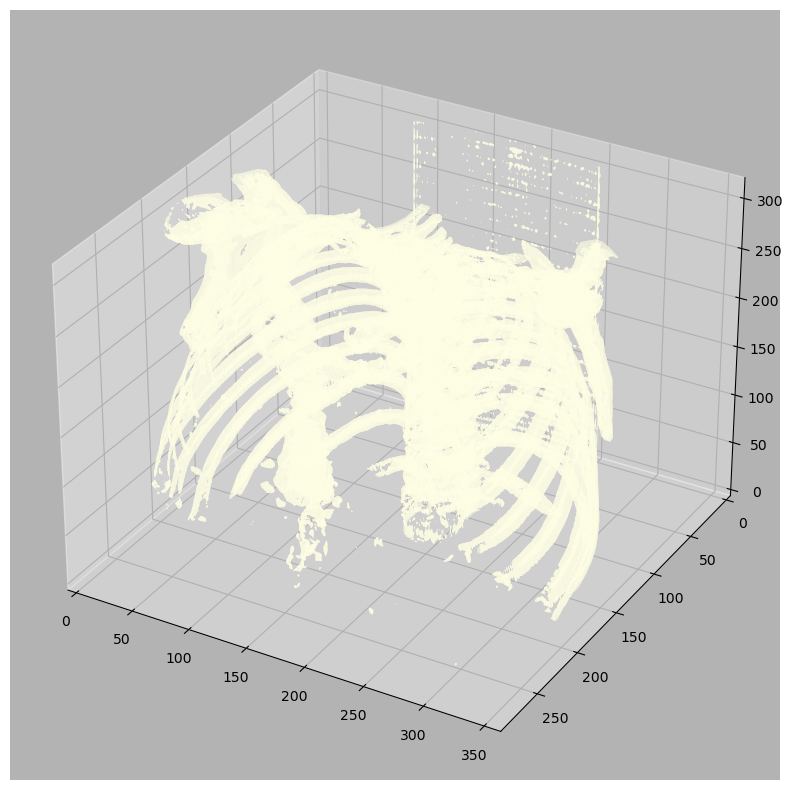

In [17]:
v, f = make_mesh(imgs_after_resamp, 350)
plt_3d(v, f)

## Segment the lungs in the chest and create a mask

In [7]:
# segmentation
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    # Standardize the pixel values by subtracting the mean and dividing by the standard deviation
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std 
    
    # Find the average pixel value near the lungs to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, move underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean

    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    # k means: method that aims to partition n observations into k clusters where each
    # observation belongs to the clusters w the nearest mean
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers) # threshold between soft tissue/bone and lung/air
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3])) #erode away boundaries of regions of foreground pixels
    dilation = morphology.dilation(eroded,np.ones([8,8])) #enlarge boundaries of regions of foreground pixels

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels) # return unique elements in array
    regions = measure.regionprops(labels) # measure properties of labeled image regions
    good_labels = []
    for prop in regions:
        B = prop.bbox # bounding box
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

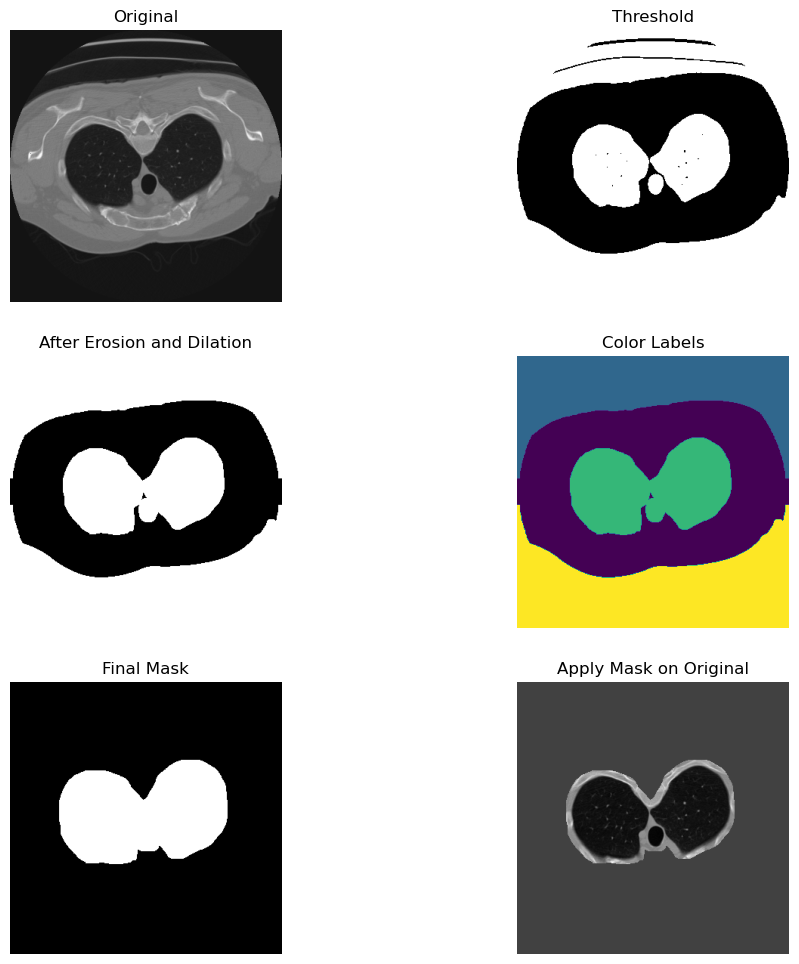

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [8]:
# single slice example at each step
img = imgs_after_resamp[260]
make_lungmask(img, display=True)

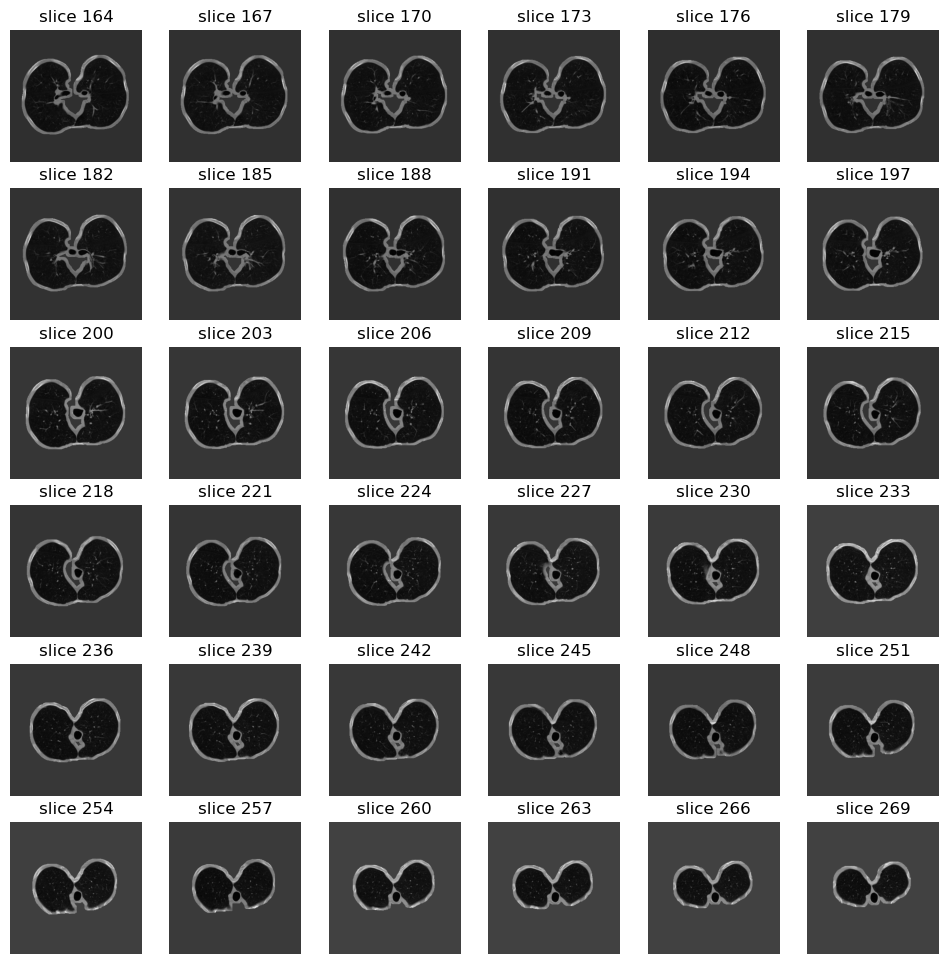

In [15]:
# apply make to all slices
masked_lung = []

for img in imgs_after_resamp:
    masked_lung.append(make_lungmask(img))

sample_stack(masked_lung, start_with=164, show_every=3)